### Import the required libraries and modules:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/Chase

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/Chase


### Unzip the data:

In [ ]:
# !unzip new_data.zip

### Construct the Model:

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE



### Training the Model:

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 8
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model1.h5")
csv_path = os.path.join("files", "data1.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model1 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 4])

model1.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 8
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model2.h5")
csv_path = os.path.join("files", "data2.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model2 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2])

model2.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.2862 - dice_coef: 0.1954 - iou: 0.1085 - recall_1: 0.5717 - precision_1: 0.2532
Epoch 1: val_loss improved from inf to 1.58655, saving model to files/model2.h5
18/18 [==============================] - 44s 2s/step - loss: 1.2862 - dice_coef: 0.1954 - iou: 0.1085 - recall_1: 0.5717 - precision_1: 0.2532 - val_loss: 1.5865 - val_dice_coef: 0.1108 - val_iou: 0.0587 - val_recall_1: 0.2464 - val_precision_1: 0.0365 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.9918 - dice_coef: 0.3115 - iou: 0.1849 - recall_1: 0.6557 - precision_1: 0.5662
Epoch 2: val_loss improved from 1.58655 to 1.56375, saving model to files/model2.h5
18/18 [==============================] - 39s 2s/step - loss: 0.9918 - dice_coef: 0.3115 - iou: 0.1849 - recall_1: 0.6557 - precision_1: 0.5662 - val_loss: 1.5637 - val_dice_coef: 0.1106 - val_iou: 0.0585 - val_recall_1: 6.9228e-04 - val

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model3.h5")
csv_path = os.path.join("files", "data3.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model3 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 2, 2, 2])

model3.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.9327 - dice_coef: 0.3553 - iou: 0.2198 - recall_3: 0.6669 - precision_3: 0.4972
Epoch 1: val_loss improved from inf to 1.34513, saving model to files/model3.h5
70/70 [==============================] - 133s 1s/step - loss: 0.9327 - dice_coef: 0.3553 - iou: 0.2198 - recall_3: 0.6669 - precision_3: 0.4972 - val_loss: 1.3451 - val_dice_coef: 0.1028 - val_iou: 0.0542 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.6558 - dice_coef: 0.5078 - iou: 0.3411 - recall_3: 0.7159 - precision_3: 0.7689
Epoch 2: val_loss improved from 1.34513 to 1.20301, saving model to files/model3.h5
70/70 [==============================] - 110s 2s/step - loss: 0.6558 - dice_coef: 0.5078 - iou: 0.3411 - recall_3: 0.7159 - precision_3: 0.7689 - val_loss: 1.2030 - val_dice_coef: 0.0898 - val_iou: 0.0471 - val_recall_3: 0.0000

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 1
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model4.h5")
csv_path = os.path.join("files", "data4.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model4 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 1, 2, 2])

model4.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 8 - 8
Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.8178 - dice_coef: 0.4167 - iou: 0.2683 - recall_4: 0.6746 - precision_4: 0.5998
Epoch 1: val_loss improved from inf to 1.21477, saving model to files/model4.h5
140/140 [==============================] - 339s 2s/step - loss: 0.8178 - dice_coef: 0.4167 - iou: 0.2683 - recall_4: 0.6746 - precision_4: 0.5998 - val_loss: 1.2148 - val_dice_coef: 0.0941 - val_iou: 0.0494 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.5693 - dice_coef: 0.5684 - iou: 0.3985 - recall_4: 0.7272 - precision_4: 0.8180
Epoch 2: val_loss improved from 1.21477 to 1.17839, saving model to files/model4.h5
140/140 [==============================] - 304s 2s/step - loss: 0.5693 - dice_coef: 0.5684 - iou: 0.3985 - recall_4: 0.7272 - precision_4: 0.8180 - val_loss: 1.1784 - val_dice_coef: 0.0687 - val_iou: 0.0356 - val_recall_4

### Evaluating the Model:

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.models import load_model

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model1.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score1 = [s[1:] for s in SCORE]
score1 = np.mean(score1, axis=0)
print(f"Accuracy: {score1[0]:0.5f}")
print(f"F1: {score1[1]:0.5f}")
print(f"Jaccard: {score1[2]:0.5f}")
print(f"Recall: {score1[3]:0.5f}")
print(f"Precision: {score1[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score1.csv")

100%|██████████| 8/8 [00:23<00:00,  2.89s/it]


Accuracy: 0.96894
F1: 0.71900
Jaccard: 0.56177
Recall: 0.81190
Precision: 0.64825


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model2.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score2 = [s[1:] for s in SCORE]
score2 = np.mean(score2, axis=0)
print(f"Accuracy: {score2[0]:0.5f}")
print(f"F1: {score2[1]:0.5f}")
print(f"Jaccard: {score2[2]:0.5f}")
print(f"Recall: {score2[3]:0.5f}")
print(f"Precision: {score2[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score2.csv")

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Accuracy: 0.97003
F1: 0.72280
Jaccard: 0.56639
Recall: 0.79840
Precision: 0.66517


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model3.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score3 = [s[1:] for s in SCORE]
score3 = np.mean(score3, axis=0)
print(f"Accuracy: {score3[0]:0.5f}")
print(f"F1: {score3[1]:0.5f}")
print(f"Jaccard: {score3[2]:0.5f}")
print(f"Recall: {score3[3]:0.5f}")
print(f"Precision: {score3[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score3.csv")

100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


Accuracy: 0.97228
F1: 0.75087
Jaccard: 0.60142
Recall: 0.85173
Precision: 0.67388


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model4.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score4 = [s[1:] for s in SCORE]
score4 = np.mean(score4, axis=0)
print(f"Accuracy: {score4[0]:0.5f}")
print(f"F1: {score4[1]:0.5f}")
print(f"Jaccard: {score4[2]:0.5f}")
print(f"Recall: {score4[3]:0.5f}")
print(f"Precision: {score4[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score4.csv")

100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Accuracy: 0.97168
F1: 0.73866
Jaccard: 0.58652
Recall: 0.81982
Precision: 0.67560


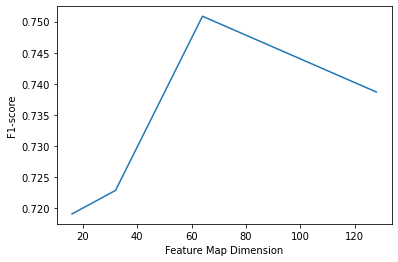

In [ ]:
import matplotlib.pyplot as plt

z_dim = [16, 32, 64, 128]
final_score = [score1[1], score2[1], score3[1], score4[1]]

plt.plot(z_dim, final_score)  
plt.xlabel("Feature Map Dimension")
plt.ylabel("F1-score")
plt.show()  

In [ ]:
print(score1)

[0.96894073 0.71900487 0.56177057 0.81189774 0.64824796]


In [ ]:
print(score2)

[0.97003126 0.72279578 0.56638867 0.79839705 0.66517256]


In [ ]:
print(score3)

[0.97227669 0.75087236 0.60141671 0.85172657 0.67387758]


In [ ]:
print(score4)

[0.97168064 0.73865579 0.5865178  0.81981999 0.67560189]
